# Satellite Use Classification |  Data Cleaning Notebook

This notebook is a part of a Satellite Use Classification Project. Before getting started with the subsequent EDA and model building notebooks in this repo this notebook should be run completely as it generates a clean dataset to work with. Note that label-encodings and other model-specific data preparation is not addressed in this notebook.


## About the Dataset

The dataset I'll be using for this project was compiled by the Union of Concerned Scientists (UCS) from several sources. The dataset contains information about satellites that are currently active and in orbit.




# Data Cleaning Process

The cleaning process in this notebook is as follows:
1. Load data from UCS source
2. Explore & remove unnecessary columns
3. Convert columns to appropriate types
4. Address NULL value
5. Handling duplicate values within columns
6. Clean text-based values (Normalize case, remove whitespace, standardize spelling/punctuation, etc.)


### Notebook Inputs

In order to run this notebook, you'll want to start by downloading the original dataset from the UCS website, at this URL: https://www.ucsusa.org/resources/satellite-database. The dataset is available in text and excel format, for this notebook we'll work with the excel version. We'll also be using the Official Names only version.

For reference I will be working with the dataset from 5-1-2023.

### Notebook Outputs

At the end of this notebook, we will output the cleaned data to a csv called `satellite_db_clean.csv` that can be loaded in the subsequent notebooks.

## Loading the Data

I was unable to download the data directly using this notebook, so instead I downloaded it manullay from the UCS website, and am loading the data below using `read_excel` in Pandas, which allows us to read the data in as a Pandas DataFrame object.


In [1]:
import pandas as pd
# Update filename as necessary
satellite_db_filename = 'UCS-Satellite-Database-Officialname 5-1-2023.xlsx'
sat_df = pd.read_excel(satellite_db_filename)
sat_df.head()

,Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),...,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66
0,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,Infrared Imaging,LEO,Non-Polar Inclined,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAC AIS-Sat1 (Kelpie 1),United Kingdom,United Kingdom,AAC Clyde Space,Commercial,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aalto-1,Finland,Finland,Aalto University,Civil,Technology Development,NaN,LEO,Sun-Synchronous,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAt-4,Denmark,Denmark,University of Aalborg,Civil,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABS-2,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
print(f"This dataset has {sat_df.shape[0]} entries and {sat_df.shape[1]} attributes.")
print(f"Available Attributes:\n\n{sat_df.dtypes}")

This dataset has 7560 entries and 67 attributes.
Available Attributes:

Current Official Name of Satellite    object
Country/Org of UN Registry            object
Country of Operator/Owner             object
Operator/Owner                        object
Users                                 object
                                       ...  
Unnamed: 62                           object
Unnamed: 63                           object
Unnamed: 64                           object
Unnamed: 65                           object
Unnamed: 66                           object
Length: 67, dtype: object


## Helper Function Defiitions

In [3]:
from re import U
import pandas as pd
import matplotlib.pyplot as plt
# Helpers
def plot_top_n_histogram(df, column_name, n):
    # Get the unique values and their counts
    value_counts = df[column_name].value_counts()

    # If there are more than n unique values, take the top n
    if len(value_counts) > n:
        value_counts = value_counts.head(n)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    # value_counts.plot(kind='hist', density=True)
    (value_counts / len(df)).plot(kind='bar')
    plt.xlabel(f'{column_name} Values')
    plt.ylabel('Density')
    plt.title(f'Top {n} values in {column_name}')
    plt.xticks(rotation=90)
    plt.show()

def plot_dates(df: pd.DataFrame, column: str,):
  launches_per_year = df.groupby(df[column].dt.year).size()
  launches_per_year.plot(kind='bar', xlabel='Year', ylabel='Number of Launches', title='Launches by Year')
  plt.show()

def column_overview(df: pd.DataFrame, column: str, show_plot: bool = False, n:int = 50) -> None:
    print(f"Column: {column}")
    print(f"Type: {df[column].dtype}")
    unique_values = df[column].unique()
    print(f"Found {len(unique_values)} unique values")
    if show_plot:
        if df[column].dtype == 'datetime64[ns]':
          plot_dates(df, column)
        else:
          num_values = len(df[column].unique())
          if num_values < n:
            n = num_values
          plot_top_n_histogram(df, column, n=n)
    else:
      try:
        unique_values = sorted(df[column].unique().tolist())
        print(unique_values)
      except Exception:
        print(unique_values)


## Initial Data Cleaning

TODO: Add Data Cleaning Summary
- remove unnecessary columns
- Check for + handle null values



### Removing Unnecessary Attributes

With the data loaded we can see that we have quite a lot to work with - which is good and bad. We have over 7500 entries, which will be good when we get to building our classifier. However, we also have 67 attributes to work with, so before we get into any major analysis or model building we'll want to remove attributes from our dataset that are not going to provide value in building our model.

To start, we can take a look and see if there are any attributes that don't contextually make sense to inclde as a part of our classifier.

- There are several `Source` and `Unnamed` columns in the dataset these are mostly NaN, comments or hyperlinks provided for reference.
- `Comments` is mostly NaN with occasional comments about the sattelite
- `Current Official Name of Satellite`, `NORAD Number`, and `COSPAR Number` are all identifiers that will not be needed


We can start by dropping these values.

In [4]:
# Dropping unnecessary columns:
unnamed_columns = [col for col in sat_df.columns if 'Unnamed' in col]
source_columns = [col for col in sat_df.columns if 'Source' in col]

columns_to_drop =  unnamed_columns + source_columns + ['Current Official Name of Satellite', 'NORAD Number', 'COSPAR Number', 'Comments']
sat_df = sat_df.drop(columns=columns_to_drop)
print(sat_df.dtypes)

Country/Org of UN Registry     object
Country of Operator/Owner      object
Operator/Owner                 object
Users                          object
Purpose                        object
Detailed Purpose               object
Class of Orbit                 object
Type of Orbit                  object
Longitude of GEO (degrees)    float64
Perigee (km)                  float64
Apogee (km)                   float64
Eccentricity                  float64
Inclination (degrees)         float64
Period (minutes)              float64
Launch Mass (kg.)             float64
Dry Mass (kg.)                 object
Power (watts)                  object
Date of Launch                 object
Expected Lifetime (yrs.)      float64
Contractor                     object
Country of Contractor          object
Launch Site                    object
Launch Vehicle                 object
dtype: object


Next, I noticed that a few attributes have related/dependent attributes. For example we have:
- `Contractor` and `Country of Contractor`
- `Operator/Owner` and `Country of Operator/Owner`

When we begin building the model, we really want to avoid introducing dependent variables and instead pick variables that can independently represent the feature. In this case, we can take a look at each feature's data using the code below.


Column: Operator/Owner
Type: object
Found 668 unique values


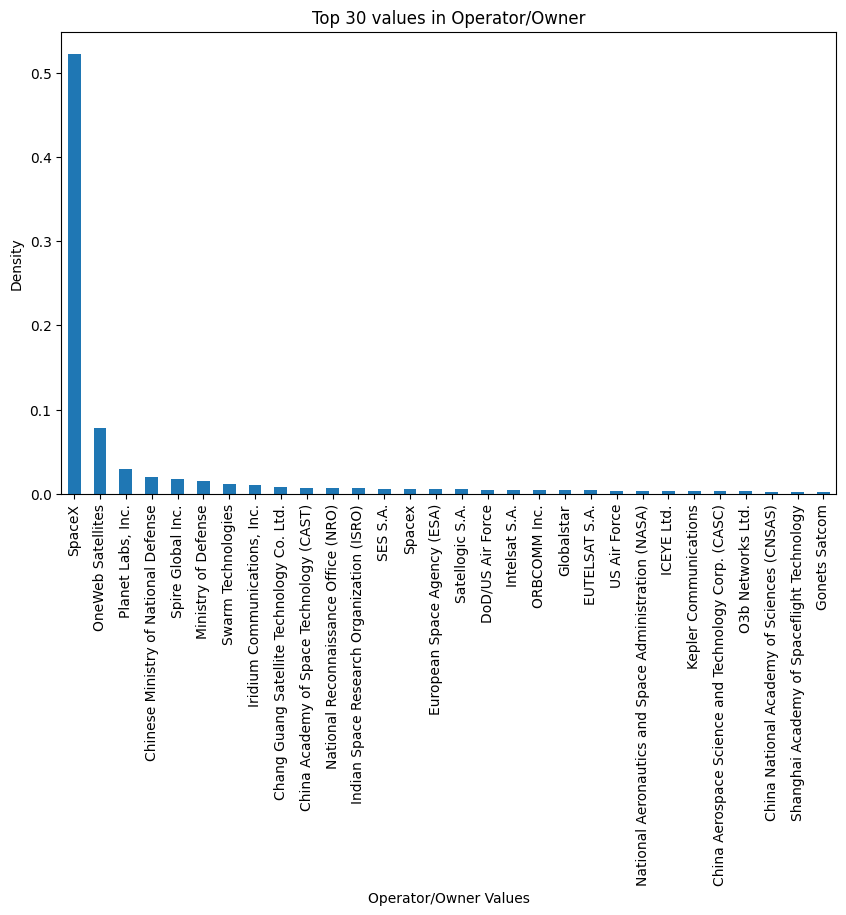

In [5]:
column_overview(sat_df, 'Operator/Owner', show_plot=True, n=30)

Column: Contractor
Type: object
Found 577 unique values


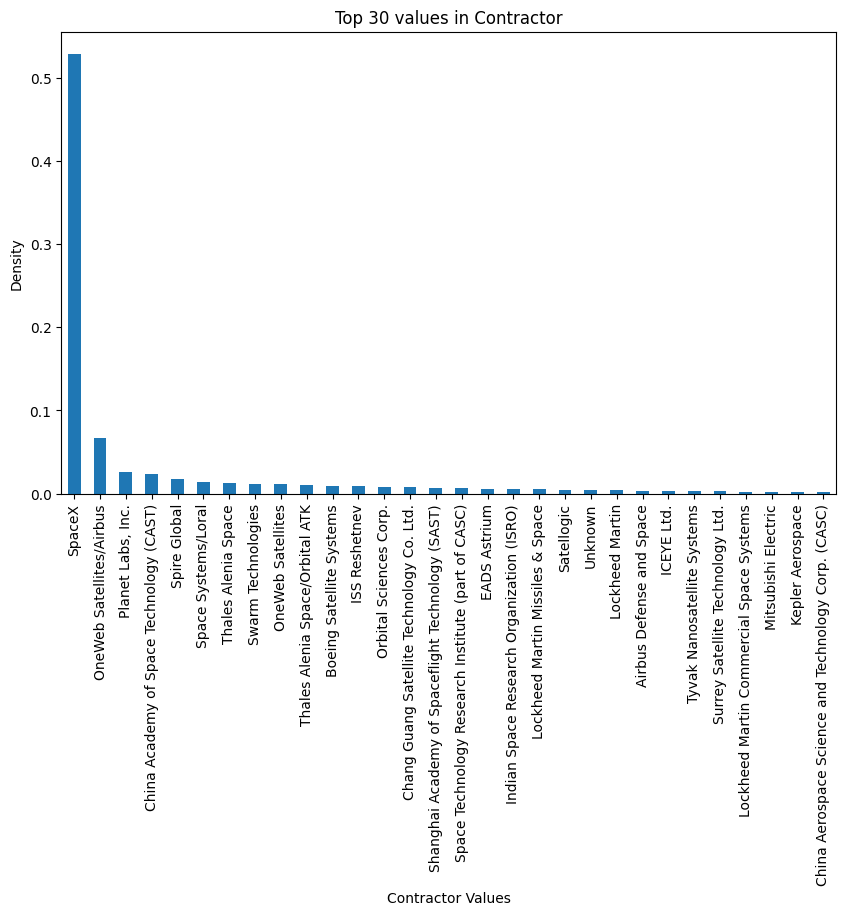

In [6]:
column_overview(sat_df, 'Contractor', show_plot=True, n=30)

What we end up seeing is that the `Contractor` and `Operator/Owner` attributes have over 500 unique attributes each. We can see that there are several values that have variations in spelling/formatting that would make cleaning these attributes a heavy lift with this many values (For example you can see that for `Operator/Owner` SpaceX is listed as both SpaceX and Spacex). We could certainly take time to clean these values, however we have another attribute for each that may make more sense to work with, the country.

Column: Country of Operator/Owner
Type: object
Found 105 unique values


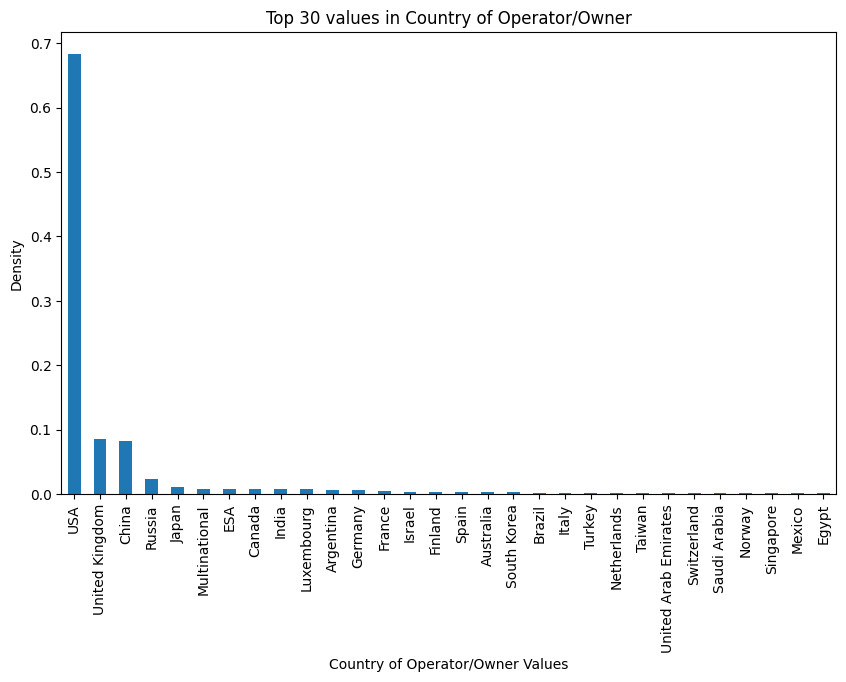

In [7]:
column_overview(sat_df, 'Country of Operator/Owner', show_plot=True, n=30)

Column: Country of Contractor
Type: object
Found 100 unique values


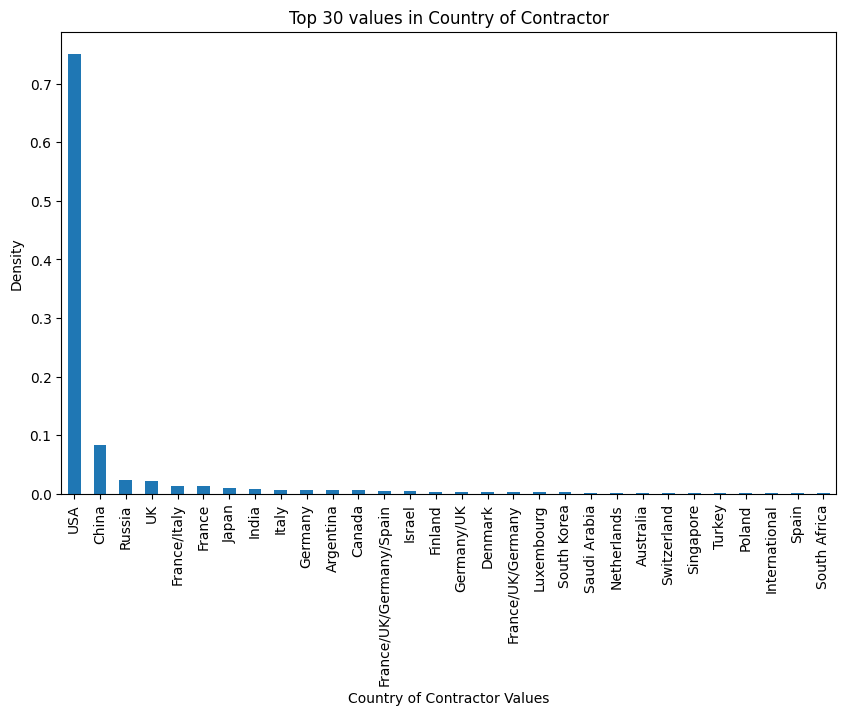

In [8]:
column_overview(sat_df, 'Country of Contractor', show_plot=True, n=30)

As we can see these attributes have fewer values, are more standardized, and have fewer duplicates to work with. For this reason we can drop the `Operator/Owner` and `Contractor` columns.

It's also possible we won't need both of these attributes later on either, but we'll address that during feature selection.

In [9]:
sat_df = sat_df.drop(columns=['Operator/Owner', 'Contractor'])

Finally, we can take a look at the country attributes, as there are several attributes available to work with. If possible, it would be nice to only have to work with one geographic feature - especially since we can see from the above that many of the Country values are overwhelmingly from the US/China, I don't anticipate them having a large affect on the end classification.

Below we have a corelation plot to see how correlated the country attributes are.

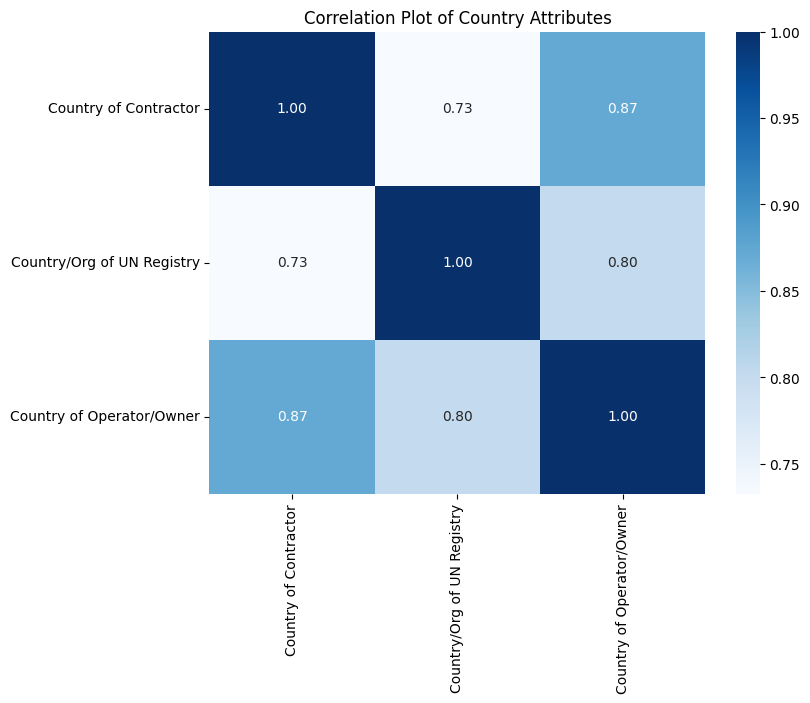

In [10]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
country_attributes = [
    'Country of Contractor',
    'Country/Org of UN Registry',
    'Country of Operator/Owner'
]

country_subset = sat_df[country_attributes]
label_encoder = LabelEncoder()
df_encoded = country_subset.apply(label_encoder.fit_transform)

corr_df = df_encoded.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Plot of Country Attributes')
plt.show()

From the above, we see that they are all very highly correlated - so it would make sense to pick just one of these features to work with. Since the `Country of Operator/Owner` seems to have highest all-arround correlation this would be a good representative feature. We can drop the other two.

In [11]:
sat_df = sat_df.drop(columns=['Country of Contractor', 'Country/Org of UN Registry'])

### Converting Column Types

Most of our attributes are correctly typed, however the `Date of Launch` is still listed as a plain object. Using the code below we can update that to a datetype object.

In [12]:
"""
Create temp column called date_tmp and convert the values to datetimes
if we use errors='coerce' any vlaues that can't be converted are marked NaT
"""
sat_df['date_tmp'] = pd.to_datetime(sat_df['Date of Launch'], errors='coerce')

# Check how many NaT values we have
na_values = sat_df['date_tmp'].isna()
na_rows = sat_df[na_values]
na_rows.head()

,Country of Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Eccentricity,Inclination (degrees),Period (minutes),Launch Mass (kg.),Dry Mass (kg.),Power (watts),Date of Launch,Expected Lifetime (yrs.),Launch Site,Launch Vehicle,date_tmp
240,USA,Commercial,Earth Observation,Optical Imaging,LEO,Non-Polar Inclined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rocket Lab Launch Complex 1,Electron,NaT
349,USA,Commercial,Earth Observation,Meteorology,LEO,Sun-Synchronous,0.0,485.0,500.0,0.001093,97.5,94.5,10.0,NaN,NaN,11/29/018,NaN,Satish Dhawan Space Centre,PSLV,NaT
7186,China,Commercial,Meteorological,NaN,LEO,Sun-Synchronous,0.0,494.0,511.0,0.001237,97.2,95.1,50.0,50,NaN,1/9//2023,2.0,Jiuquan Satellite Launch Center,Ceres,NaT


In [13]:
# NaT values were formatted incorrectly in dataset - we can manually update them
sat_df.at[349, 'date_tmp'] = pd.to_datetime('11/29/2018', format='%m/%d/%Y')
sat_df.at[7186, 'date_tmp'] = pd.to_datetime('1/9/2023', format='%m/%d/%Y')
# Set date_tmp to be Date of Launch now that it's updated
sat_df = sat_df.drop(columns=['Date of Launch'])
sat_df = sat_df.rename(columns={'date_tmp': 'Date of Launch'})
print(sat_df.loc[349]) # Confirm Date of Launch was updated

Country of Operator/Owner                            USA
Users                                         Commercial
Purpose                                Earth Observation
Detailed Purpose                             Meteorology
Class of Orbit                                       LEO
Type of Orbit                            Sun-Synchronous
Longitude of GEO (degrees)                           0.0
Perigee (km)                                       485.0
Apogee (km)                                        500.0
Eccentricity                                    0.001093
Inclination (degrees)                               97.5
Period (minutes)                                    94.5
Launch Mass (kg.)                                   10.0
Dry Mass (kg.)                                       NaN
Power (watts)                                        NaN
Expected Lifetime (yrs.)                             NaN
Launch Site                   Satish Dhawan Space Centre
Launch Vehicle                 

## Handling Null Values

Using the code below we can see the breakdown of null values by attribute. Most of the attributes only have a few Null values. Since the null count is so small for most of these attributes, I feel we can comfortably remove the entries with null values. There are, however, a few that have a higher concentration of nulls.


The `Detailed Purpose`, `Dry Mass (kg.) `, and `Power (watts)` values appear to be NaN at least 80% of the time, we can start by dropping these values. As an added assurance, we have access to the `Purpose` for each satellite which is reliably filled in so removing `Detailed Purpose` will not cause problems when building the classifier.


In [14]:
print(f"Number of nulls per column:\n\n{sat_df.isnull().sum()}")

Number of nulls per column:

Country of Operator/Owner        0
Users                            0
Purpose                          0
Detailed Purpose              6306
Class of Orbit                   0
Type of Orbit                  651
Longitude of GEO (degrees)       3
Perigee (km)                     7
Apogee (km)                      7
Eccentricity                    11
Inclination (degrees)            4
Period (minutes)                56
Launch Mass (kg.)              245
Dry Mass (kg.)                6793
Power (watts)                 6981
Expected Lifetime (yrs.)      2110
Launch Site                      0
Launch Vehicle                   0
Date of Launch                   1
dtype: int64


In [15]:
sat_df = sat_df.drop(columns=['Detailed Purpose', 'Dry Mass (kg.)', 'Power (watts)'])

Next, let's look at `Expected Lifetime (yrs.)`. Since there are over 2000 null `Expected Lifetime (yrs.)` values, we want to determine if this data is useful to the model. If it is we either need to find a value to fill in, or drop the null entries. If it's not we may be able to drop the column entirely.

In the plot below I plot the Current age of the satellite against it's expected lifetime. If expected lifetime were useful to use we'd see a strong correlation between the afe and expected lifetime, however this is not the case. Since there is no correlation we can remove it.

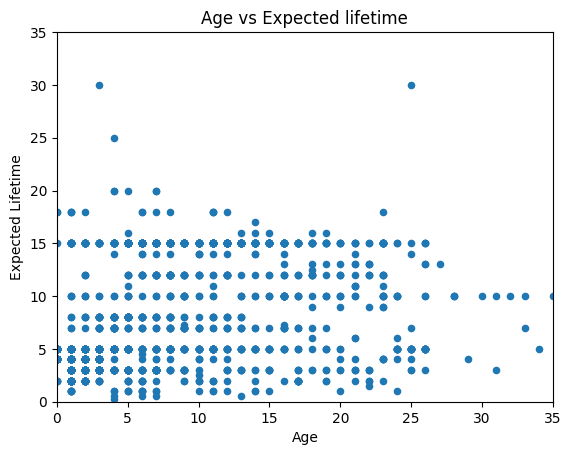

In [16]:
from datetime import datetime
sat_df['Age'] = (datetime.now() - sat_df['Date of Launch']).astype('<m8[Y]')
sat_df.plot(x='Age', y = 'Expected Lifetime (yrs.)', kind='scatter')
plt.xlim(0, 35)
plt.ylim(0, 35)
plt.xlabel('Age')
plt.ylabel('Expected Lifetime')
plt.title('Age vs Expected lifetime')
plt.show()

In [17]:
sat_df = sat_df.drop(['Age', 'Expected Lifetime (yrs.)'], axis=1)

Finally we can look at the null `Type of Orbit `. `Type of Orbit` is actually a more specific version of `Class of Orbit` so we can use that to help us fill in values, and then drop the `Class of Orbit` column.



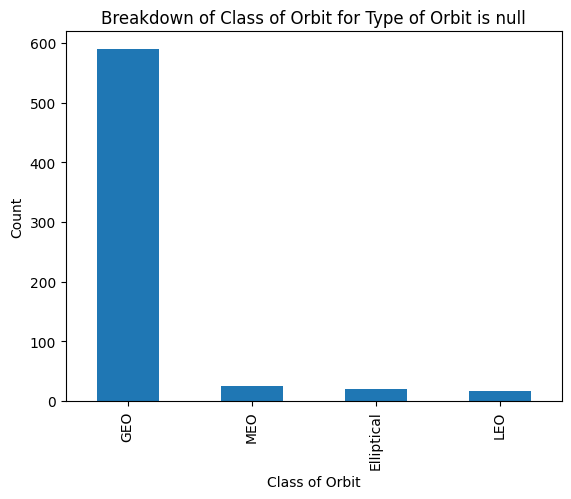

In [18]:
null_type_df = sat_df[sat_df['Type of Orbit'].isnull()]

# Plot the breakdown of 'Class of Orbit' for rows where 'Type of Orbit' is null
null_type_df['Class of Orbit'].value_counts().plot(kind='bar')
plt.xlabel('Class of Orbit')
plt.ylabel('Count')
plt.title('Breakdown of Class of Orbit for Type of Orbit is null')
plt.show()

The majority of Null values are from satellites in GEO orbits. GEO orbits are actually a type of Equatorial oribit within a specific altitude range, we can update these then to be `EQUATORIAL`.

In [19]:
# For entries, if Class of Orbit is GEO and have NaN Type of Orbit we can fill that in as either GEO (this is a type of EQUATORIAL at a specific altitude)
sat_df.loc[sat_df['Class of Orbit'] == 'GEO', 'Type of Orbit'] = sat_df.loc[sat_df['Class of Orbit'] == 'GEO', 'Type of Orbit'].fillna("Equatorial")
print(f"Remaining Null Values: {sat_df['Type of Orbit'].isnull().sum()}")

Remaining Null Values: 61


The remaining Null value count is pretty low compared to the overall number of rows we have to work with we can just drop the remaining rows with Null entries later. And since we're done with `Class of Orbit` that column can be removed as well.

In [20]:
sat_df = sat_df.drop(['Class of Orbit'], axis=1)

Finally - let's drop the remaining entries with Null values.

In [21]:
# Drop all remaining NaNs

non_nan_rows = sat_df.notnull().all(axis=1)
sat_df = sat_df[non_nan_rows]
print(f"Number of nulls per column:\n\n{sat_df.isnull().sum()}")
print(f"Remaining: {sat_df.shape[0]} entries and {sat_df.shape[1]} attributes")

Number of nulls per column:

Country of Operator/Owner     0
Users                         0
Purpose                       0
Type of Orbit                 0
Longitude of GEO (degrees)    0
Perigee (km)                  0
Apogee (km)                   0
Eccentricity                  0
Inclination (degrees)         0
Period (minutes)              0
Launch Mass (kg.)             0
Launch Site                   0
Launch Vehicle                0
Date of Launch                0
dtype: int64
Remaining: 7201 entries and 14 attributes


## Exploring our Target Attribute

In this project the goal is to see if we can develop a model that reliably can determine a Satellite's purpose given some set of features. The target attribute we'll be working with is called Purpose - below we see that there are 31 unique values for Purpose, and most of them have very few entries. The satellites we do have to work with are overwhelmingly classified as Communications.

This introduces a problem for our model, it will be biased towards correctly classifying communicastions satellites unless we can find a way to offest the bias (I'll discuss this more during model building).

Column: Purpose
Type: object
Found 31 unique values


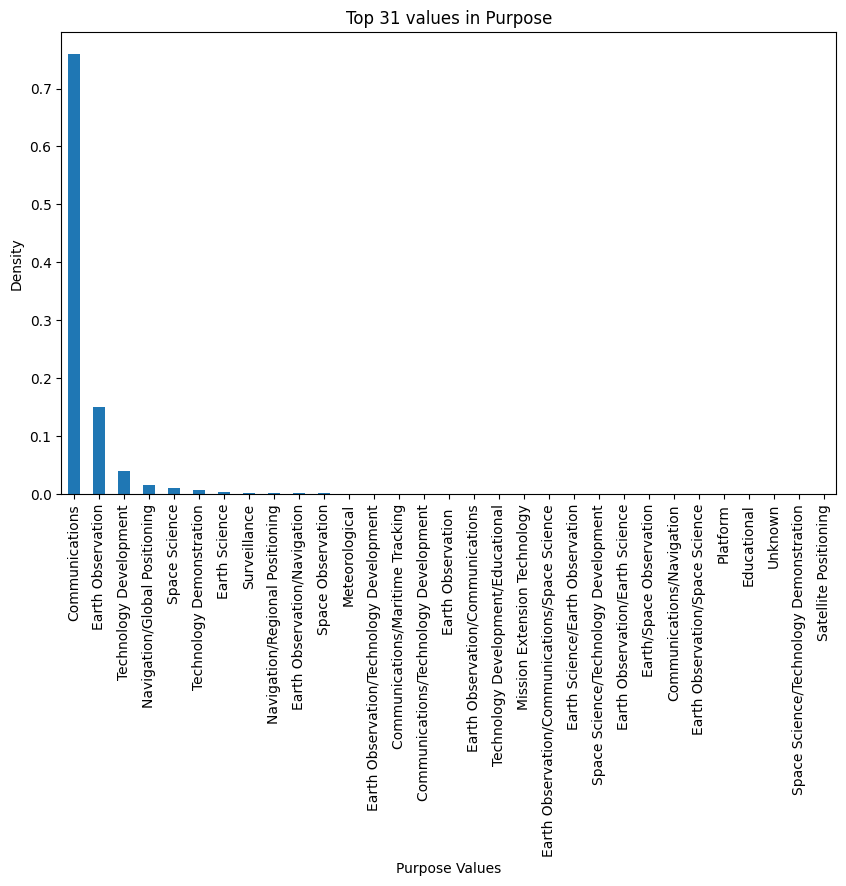

In [22]:
column_overview(sat_df, 'Purpose', show_plot = True)

While the bias is a big issue, another issue is that many of the classifications have very few data points, which means it may be hard to classify those. The ones with few datapoints tend to be ones with multiple classifications. One approach I'd like to try is to reduce the number of classes we have. This next section of code will create a subset of Purposes that does not allow for multiple classification to simplify what the classifier has to work with. We'll make an assumption and say that the first one listed in the list is the primary use and later we can try building additional models to see how this affects our accuracy.

Column: Purpose_subset
Type: object
Found 17 unique values


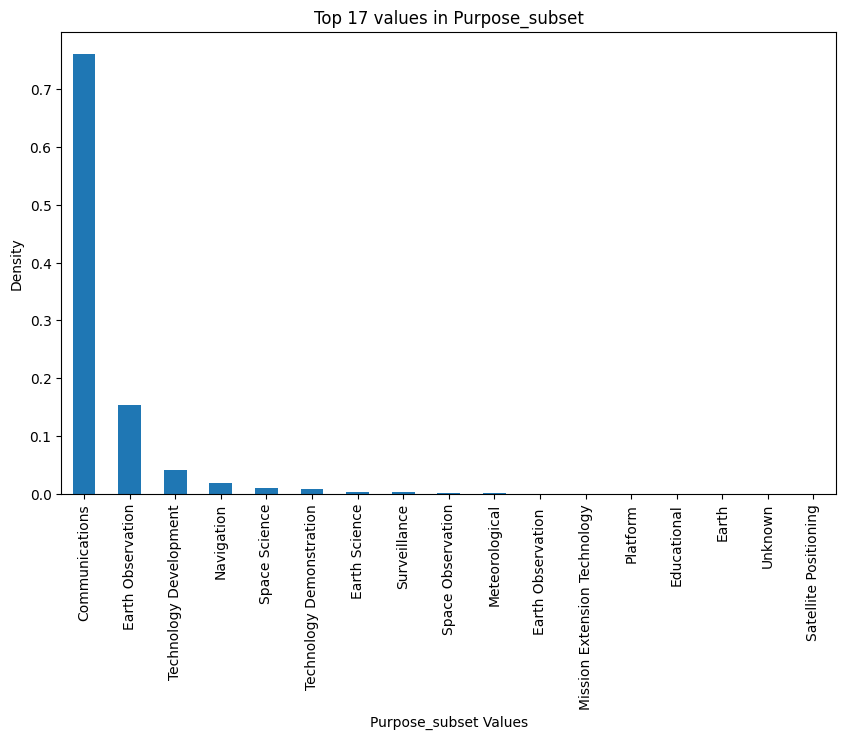

In [23]:
sat_df['Purpose_subset'] = sat_df['Purpose'].str.split('/').str[0]
column_overview(sat_df, 'Purpose_subset', show_plot=True)

## Cleaning Up String Values & Adding Encodings
A lot of the data we have is text-based which makes it prone to duplicate entries or misformatted text, especially if any data has been entered manually or if the data is compiled from multiple sources. The code below is designed to clean up our text to avoid some of the most common issues. The updates include the following:
- Remove leading/trailing whitespace
- Noramlize case to Upper
- Replace brackets with parentheses for consistency
- Update commonly misspelled words found while looking at raw data
- Sort values separated by `/` (example: in `Users` some have multiple categories like `Civil/Commercial`, if we have `Commercial/Civil` it is treated differently)

Additionally, for all of the text-based attributed, we are also going to create encodings so that they can be used by the model later on, as most models don't work well with string data.



In [24]:
for col in sat_df.columns:
    if sat_df[col].dtype == 'object':
        # Strip whitespace from each value in the column
        sat_df[col] = sat_df[col].str.strip()
        sat_df[col] = sat_df[col].apply(lambda x: '/'.join(sorted(str(x).split('/'))))
        sat_df[col] = sat_df[col].str.upper()
        sat_df[col] = sat_df[col].str.replace('[', '(', regex=False).str.replace(']', ')', regex=False)
        sat_df[col] = sat_df[col].str.replace('CENTRE', 'CENTER')

# Generate Clean Dataset CSV

In [25]:
sat_df.to_csv('satellite_db_clean.csv', index=False)

In [26]:
clean = pd.read_csv('satellite_db_clean.csv')

print(clean.shape)
clean.head()

(7201, 15)


,Country of Operator/Owner,Users,Purpose,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Eccentricity,Inclination (degrees),Period (minutes),Launch Mass (kg.),Launch Site,Launch Vehicle,Date of Launch,Purpose_subset
0,USA,COMMERCIAL,EARTH OBSERVATION,NON-POLAR INCLINED,0.0,566.0,576.0,0.001510,36.90,96.08,22.0,SATISH DHAWAN SPACE CENTER,PSLV,2019-12-11,EARTH OBSERVATION
1,UNITED KINGDOM,COMMERCIAL,EARTH OBSERVATION,SUN-SYNCHRONOUS,0.0,637.0,654.0,0.001510,98.00,95.00,4.0,CAPE CANAVERAL,FALCON 9,2023-01-03,EARTH OBSERVATION
2,FINLAND,CIVIL,TECHNOLOGY DEVELOPMENT,SUN-SYNCHRONOUS,0.0,497.0,517.0,0.001450,97.45,94.70,4.5,SATISH DHAWAN SPACE CENTER,PSLV,2017-06-23,TECHNOLOGY DEVELOPMENT
3,DENMARK,CIVIL,EARTH OBSERVATION,SUN-SYNCHRONOUS,0.0,442.0,687.0,0.001510,98.20,95.90,1.0,GUIANA SPACE CENTER,SOYUZ-2.1A,2016-04-25,EARTH OBSERVATION
4,MULTINATIONAL,COMMERCIAL,COMMUNICATIONS,EQUATORIAL,75.0,35778.0,35793.0,0.000178,0.08,1436.03,6330.0,GUIANA SPACE CENTER,ARIANE 5 ECA,2014-02-06,COMMUNICATIONS


In [27]:
clean.dtypes

Country of Operator/Owner      object
Users                          object
Purpose                        object
Type of Orbit                  object
Longitude of GEO (degrees)    float64
Perigee (km)                  float64
Apogee (km)                   float64
Eccentricity                  float64
Inclination (degrees)         float64
Period (minutes)              float64
Launch Mass (kg.)             float64
Launch Site                    object
Launch Vehicle                 object
Date of Launch                 object
Purpose_subset                 object
dtype: object